##  Facebook Outage (October 2021)

/tmp/ipykernel_659381/1093713375.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  announcements = df[df['type'] == 'A'].resample('5T').size()
/tmp/ipykernel_659381/1093713375.py:55: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  withdrawals = df[df['type'] == 'W'].resample('5T').size()


Facebook Outage Anomaly Detection
----------------------------------
                     Announcements  Withdrawals
timestamp                                      
2021-10-04 15:05:00             31          0.0
2021-10-04 15:10:00             25          0.0
2021-10-04 15:15:00              0          0.0
2021-10-04 15:20:00              0          0.0
2021-10-04 15:25:00              0          0.0
2021-10-04 15:30:00             21          2.0
2021-10-04 15:35:00             43          2.0
2021-10-04 15:40:00           3636        712.0
2021-10-04 15:45:00            179        207.0
2021-10-04 15:50:00           3177        907.0
2021-10-04 15:55:00             23         27.0
2021-10-04 16:00:00             14          9.0
2021-10-04 16:05:00             50        104.0
2021-10-04 16:10:00              7          0.0
2021-10-04 16:15:00              7          1.0
2021-10-04 16:20:00             11         12.0
2021-10-04 16:25:00              7          0.0
2021-10-04 16:30:00

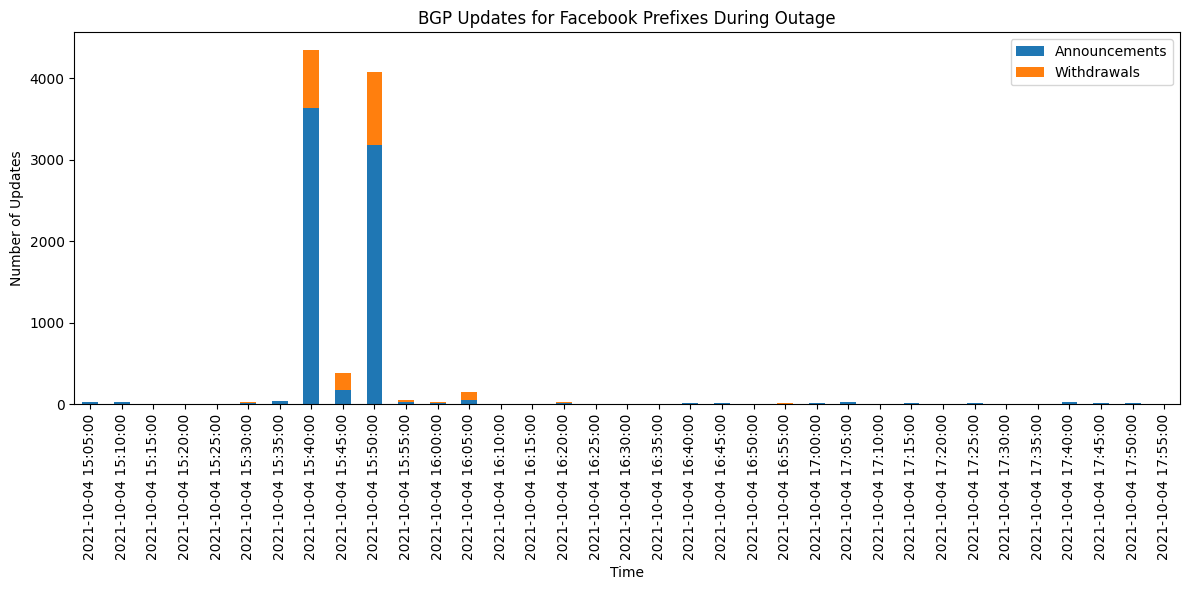

In [2]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define time window around the outage
start_time = "2021-10-04 15:00:00"  # UTC
end_time = "2021-10-04 18:00:00"    # UTC

# Facebook's ASN and prefixes
facebook_asn = "32934"
facebook_prefixes = [
    "57.144.0.0/14",
    "129.134.0.0/17",
    "157.240.0.0/24",
    "157.240.192.0/18",
    "157.240.203.0/24",
    "185.89.216.0/22",
]

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2", "route-views3"]
)

# Add filters
for prefix in facebook_prefixes:
    stream.add_filter('prefix', prefix)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type in ["A", "W"]:
            timestamp = datetime.utcfromtimestamp(elem.time)
            data.append({
                "timestamp": timestamp,
                "type": elem.type,
                "prefix": elem.fields["prefix"],
                "peer_asn": elem.peer_asn,
                "as_path": elem.fields.get("as-path", ""),
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Resample data to 5-minute intervals
df.set_index('timestamp', inplace=True)
announcements = df[df['type'] == 'A'].resample('5T').size()
withdrawals = df[df['type'] == 'W'].resample('5T').size()

# Combine data
df_resampled = pd.DataFrame({
    'Announcements': announcements,
    'Withdrawals': withdrawals
}).fillna(0)

# Human-readable output
print("Facebook Outage Anomaly Detection")
print("----------------------------------")
print(df_resampled)

# Plotting
plt.figure(figsize=(12, 6))
df_resampled.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('BGP Updates for Facebook Prefixes During Outage')
plt.xlabel('Time')
plt.ylabel('Number of Updates')
plt.tight_layout()
plt.show()

## Amazon Route 53 Hijack (April 24, 2018)

Potential BGP Hijacking Detected
--------------------------------
             timestamp origin_asn                       as_path  peer_asn
0  2018-04-24 11:05:41      10297                    6939 10297      6939
1  2018-04-24 11:05:41      10297                    6939 10297      6939
2  2018-04-24 11:05:41      10297                    6939 10297      6939
3  2018-04-24 11:05:41      10297                    6939 10297      6939
4  2018-04-24 11:05:42      10297              54728 6939 10297     54728
5  2018-04-24 11:05:42      10297              54728 6939 10297     54728
6  2018-04-24 11:05:42      10297              47872 6939 10297     47872
7  2018-04-24 11:05:42      10297              47872 6939 10297     47872
8  2018-04-24 11:05:42      10297              18106 6939 10297     18106
9  2018-04-24 11:05:42      10297              18106 6939 10297     18106
10 2018-04-24 11:05:42      10297  134708 55329 4788 6939 10297    134708
11 2018-04-24 11:05:42      10297  134708 5532

/tmp/ipykernel_659381/1680917815.py:56: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  hijack_counts = df.resample('5T').size()


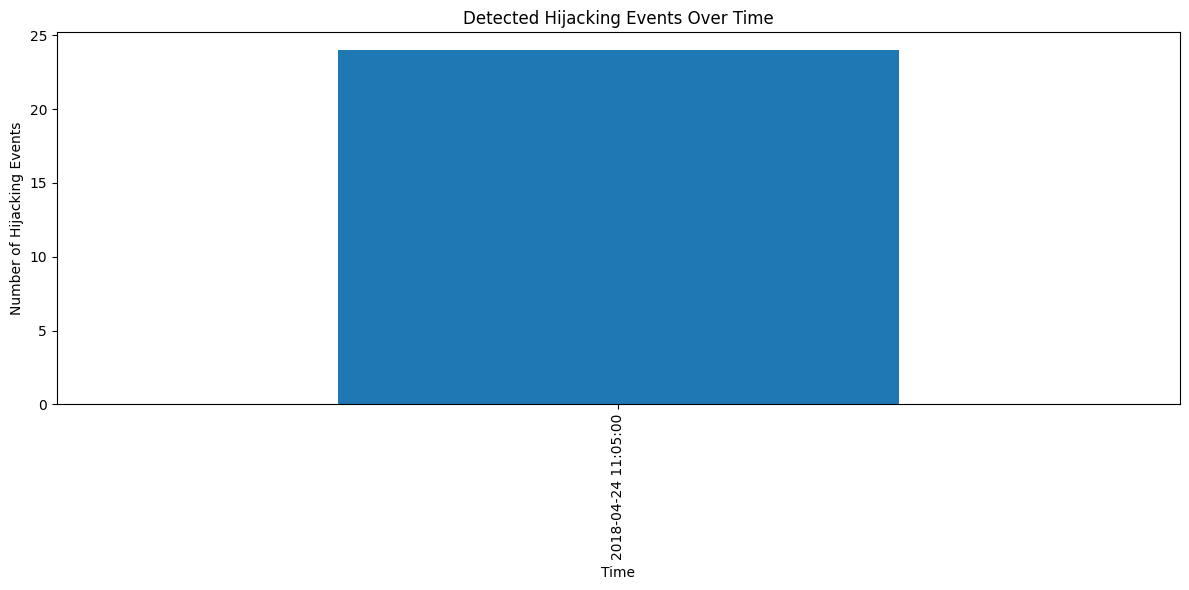

In [5]:
import pybgpstream
import pandas as pd
from datetime import datetime

# Define time window around the incident
start_time = "2018-04-24 10:00:00"  # UTC
end_time = "2018-04-24 12:00:00"    # UTC

# Target prefix and expected origin ASN
target_prefix = "205.251.192.0/23"
expected_asn = "16509"

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["rrc00", "route-views2", "route-views3"]
)

# Add filters
stream.add_filter('prefix', target_prefix)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            as_path = elem.fields.get('as-path', '')
            origin_asn = as_path.strip().split()[-1] if as_path else None
            if origin_asn and origin_asn != expected_asn:
                data.append({
                    "timestamp": timestamp,
                    "origin_asn": origin_asn,
                    "as_path": as_path,
                    "peer_asn": elem.peer_asn,
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Human-readable output
print("Potential BGP Hijacking Detected")
print("--------------------------------")
if df.empty:
    print("No hijacking events detected.")
else:
    print(df)

# Plotting
if not df.empty:
    df.set_index('timestamp', inplace=True)
    hijack_counts = df.resample('5T').size()
    hijack_counts.plot(kind='bar', figsize=(12, 6))
    plt.title('Detected Hijacking Events Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Hijacking Events')
    plt.tight_layout()
    plt.show()

## Pakistan Telecom Hijacks YouTube (February 24, 2008)

Anomalous Origin ASNs Detected for Prefix: 208.65.153.0/24
  origin_asn  counts
0      17557     113
1      36561      77


/tmp/ipykernel_671003/3506232726.py:60: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_origin_asn = df.groupby([pd.Grouper(freq='5T'), 'origin_asn']).size().unstack(fill_value=0)


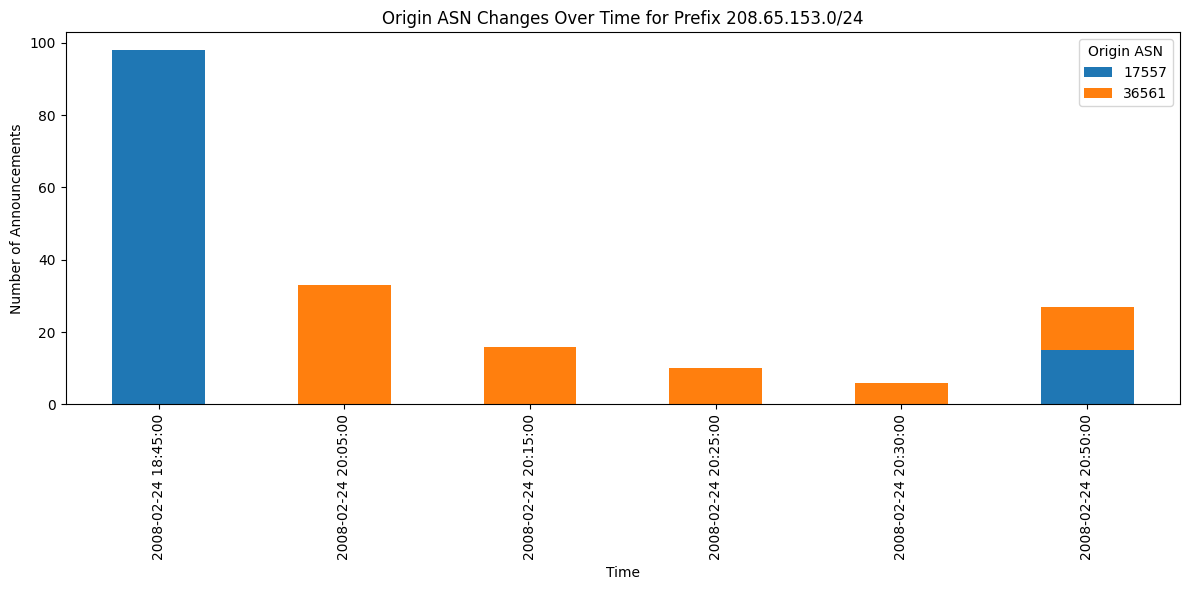

In [10]:
import pybgpstream
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Define time window around the incident
start_time = "2008-02-24 17:00:00"  # UTC
end_time = "2008-02-24 21:00:00"    # UTC

# YouTube's prefix and expected ASN
youtube_prefix = "208.65.153.0/24"

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time="2008-02-24 17:00:00",
    until_time="2008-02-24 21:00:00",
    collectors=["route-views2", "rrc00"]
)

stream.add_filter('prefix', "208.65.153.0/24")

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            prefix = elem.fields.get('prefix', '')
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                origin_asn = as_path_list[-1]
                data.append({
                    "timestamp": timestamp,
                    "prefix": prefix,
                    "origin_asn": origin_asn,
                    "as_path": as_path,
                })

df = pd.DataFrame(data)

# Analyze origin ASN changes
origin_asn_counts = df.groupby(['origin_asn']).size().reset_index(name='counts')
origin_asn_changes = origin_asn_counts[origin_asn_counts['counts'] > 0]

# Identify anomalies: Multiple origin ASNs for the same prefix
if len(origin_asn_changes) > 1:
    print("Anomalous Origin ASNs Detected for Prefix:", youtube_prefix)
    print(origin_asn_changes)
else:
    print("No anomalies detected for prefix:", youtube_prefix)

# Visualize origin ASN changes over time
df.set_index('timestamp', inplace=True)
df_origin_asn = df.groupby([pd.Grouper(freq='5T'), 'origin_asn']).size().unstack(fill_value=0)

# Plotting
df_origin_asn.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Origin ASN Changes Over Time for Prefix ' + youtube_prefix)
plt.xlabel('Time')
plt.ylabel('Number of Announcements')
plt.legend(title='Origin ASN')
plt.tight_layout()
plt.show()


## China Telecom Route Leak (April 8, 2010)

Anomalous Prefixes Detected:
                  prefix  counts
677      109.194.96.0/22    3230
759      109.197.48.0/21    1529
833     109.205.184.0/24    1746
834     109.205.186.0/24    1297
2142    110.172.189.0/24    1399
...                  ...     ...
326027    94.76.144.0/20    1407
326028    94.76.144.0/21    1403
327327   95.215.128.0/22    1562
327581     95.38.32.0/19    1766
328012     95.82.64.0/22    2001

[357 rows x 2 columns]


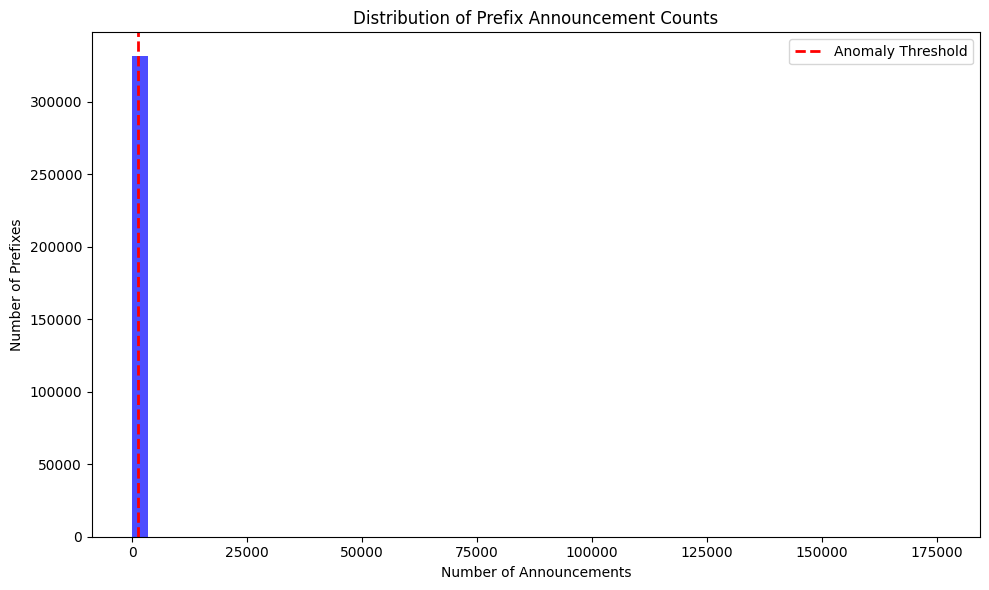

In [11]:
import pybgpstream
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Time window
start_time = "2010-04-08 00:00:00"  # UTC
end_time = "2010-04-08 23:59:59"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            prefix = elem.fields.get('prefix', '')
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                origin_asn = as_path_list[-1]
                data.append({
                    "timestamp": timestamp,
                    "prefix": prefix,
                    "origin_asn": origin_asn,
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze prefix announcement counts
prefix_counts = df.groupby('prefix').size().reset_index(name='counts')
# Identify prefixes with unusually high announcement counts
threshold = prefix_counts['counts'].mean() + 3 * prefix_counts['counts'].std()
anomalous_prefixes = prefix_counts[prefix_counts['counts'] > threshold]

print("Anomalous Prefixes Detected:")
print(anomalous_prefixes)

# Visualize the distribution of prefix announcement counts
plt.figure(figsize=(10, 6))
plt.hist(prefix_counts['counts'], bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Anomaly Threshold')
plt.title('Distribution of Prefix Announcement Counts')
plt.xlabel('Number of Announcements')
plt.ylabel('Number of Prefixes')
plt.legend()
plt.tight_layout()
plt.show()

## Indosat Hijack (April 2, 2014)

/tmp/ipykernel_659381/2277422704.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  unique_prefixes = df.groupby(pd.Grouper(freq='1H'))['prefix'].nunique()


Anomalous Increases in Unique Prefix Announcements:
Series([], Freq: h, Name: prefix, dtype: int64)


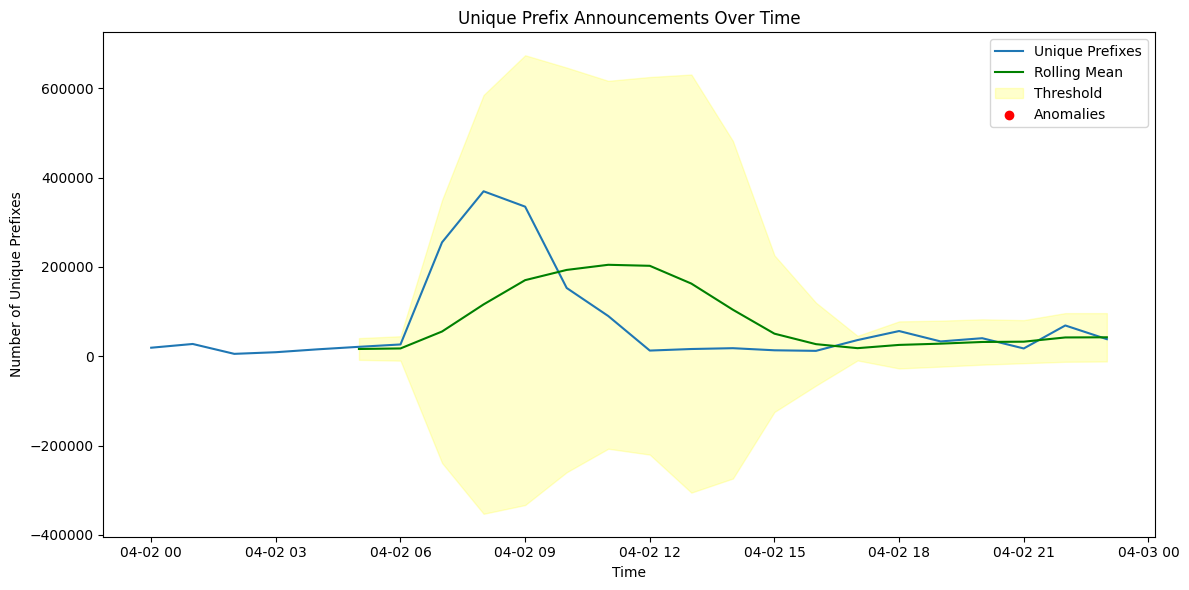

In [6]:
import pybgpstream
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Time window
start_time = "2014-04-02 00:00:00"  # UTC
end_time = "2014-04-02 23:59:59"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            prefix = elem.fields.get('prefix', '')
            as_path = elem.fields.get('as-path', '')
            data.append({
                "timestamp": timestamp,
                "prefix": prefix,
                "as_path": as_path,
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze the number of unique prefixes announced over time
df.set_index('timestamp', inplace=True)
unique_prefixes = df.groupby(pd.Grouper(freq='1H'))['prefix'].nunique()

# Calculate rolling statistics
rolling_mean = unique_prefixes.rolling(window=6).mean()  # 6-hour window
rolling_std = unique_prefixes.rolling(window=6).std()

# Identify anomalies
anomaly_threshold = rolling_mean + (rolling_std * 3)
anomalies = unique_prefixes[unique_prefixes > anomaly_threshold]

print("Anomalous Increases in Unique Prefix Announcements:")
print(anomalies)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(unique_prefixes.index, unique_prefixes.values, label='Unique Prefixes')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean', color='green')
plt.fill_between(rolling_std.index,
                 rolling_mean - (rolling_std * 3),
                 rolling_mean + (rolling_std * 3),
                 color='yellow', alpha=0.2, label='Threshold')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Unique Prefix Announcements Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Unique Prefixes')
plt.legend()
plt.tight_layout()
plt.show()

## Telekom Malaysia Route Leak (June 12, 2015)

/tmp/ipykernel_659381/775756754.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  unique_prefixes = df.groupby(pd.Grouper(freq='5T'))['prefix'].nunique()


Anomalous Increases in Unique Prefix Announcements:
timestamp
2015-06-12 08:40:00     8496
2015-06-12 08:45:00    31526
Freq: 5min, Name: prefix, dtype: int64


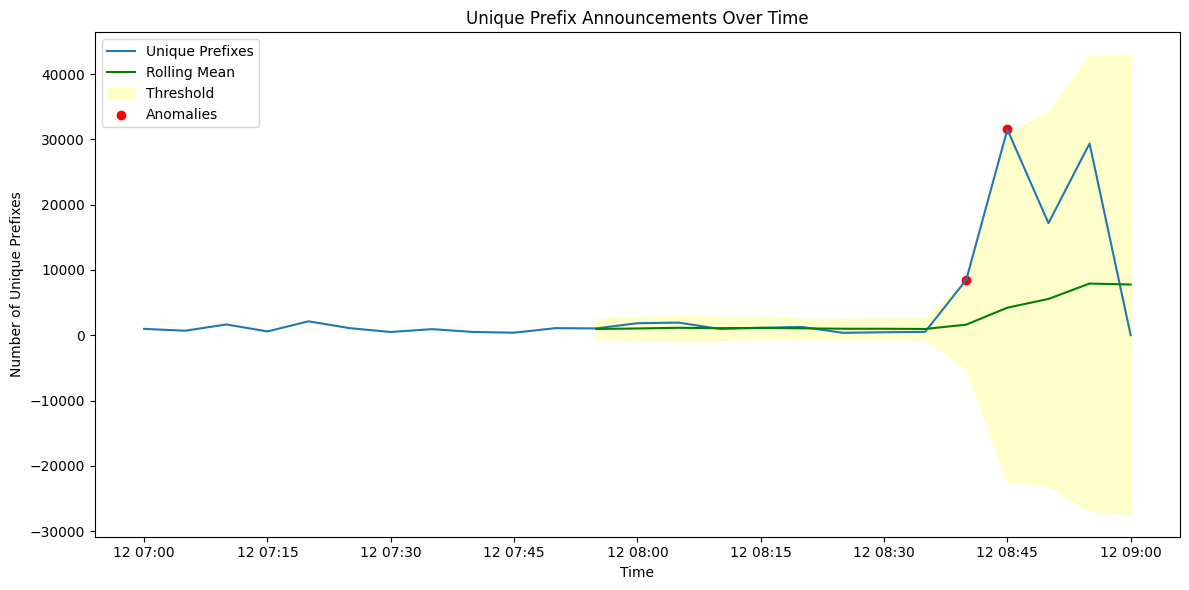

In [7]:
import pybgpstream
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Time window
start_time = "2015-06-12 07:00:00"  # UTC
end_time = "2015-06-12 09:00:00"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views.sg"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            prefix = elem.fields.get('prefix', '')
            as_path = elem.fields.get('as-path', '')
            data.append({
                "timestamp": timestamp,
                "prefix": prefix,
                "as_path": as_path,
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze the number of unique prefixes announced over time
df.set_index('timestamp', inplace=True)
unique_prefixes = df.groupby(pd.Grouper(freq='5T'))['prefix'].nunique()

# Calculate rolling statistics
rolling_mean = unique_prefixes.rolling(window=12).mean()  # 1-hour window
rolling_std = unique_prefixes.rolling(window=12).std()

# Identify anomalies
anomaly_threshold = rolling_mean + (rolling_std * 3)
anomalies = unique_prefixes[unique_prefixes > anomaly_threshold]

print("Anomalous Increases in Unique Prefix Announcements:")
print(anomalies)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(unique_prefixes.index, unique_prefixes.values, label='Unique Prefixes')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean', color='green')
plt.fill_between(rolling_std.index,
                 rolling_mean - (rolling_std * 3),
                 rolling_mean + (rolling_std * 3),
                 color='yellow', alpha=0.2, label='Threshold')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Unique Prefix Announcements Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Unique Prefixes')
plt.legend()
plt.tight_layout()
plt.show()

## Google Outage Due to BGP Misconfiguration (November 12, 2018)

In [8]:
import pybgpstream
import pandas as pd
from datetime import datetime

# Time window
start_time = "2018-11-12 21:00:00"  # UTC
end_time = "2018-11-12 23:00:00"    # UTC

# Target prefixes (Google's public DNS)
google_prefixes = ["8.8.8.0/24", "8.8.4.0/24"]

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Add prefix filters
for prefix in google_prefixes:
    stream.add_filter('prefix', prefix)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            prefix = elem.fields.get('prefix', '')
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                origin_asn = as_path_list[-1]
                data.append({
                    "timestamp": timestamp,
                    "prefix": prefix,
                    "origin_asn": origin_asn,
                    "as_path": as_path,
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze origin ASN changes
origin_asn_changes = df.groupby(['prefix', 'origin_asn']).size().reset_index(name='counts')

# Identify prefixes with multiple origin ASNs
prefix_origin_counts = df.groupby('prefix')['origin_asn'].nunique().reset_index()
anomalous_prefixes = prefix_origin_counts[prefix_origin_counts['origin_asn'] > 1]

print("Prefixes with Origin AS Changes:")
print(anomalous_prefixes)

# For anomalous prefixes, list the origin ASNs
for index, row in anomalous_prefixes.iterrows():
    prefix = row['prefix']
    origins = df[df['prefix'] == prefix]['origin_asn'].unique()
    print(f"Prefix: {prefix}, Origin ASNs: {', '.join(origins)}")

KeyError: 'prefix'

## Rostelecom Route Leak (April 1, 2020)

In [ ]:
import pybgpstream
import pandas as pd
from datetime import datetime

# Time window
start_time = "2019-06-24 08:00:00"  # UTC
end_time = "2019-06-24 12:00:00"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                path_length = len(as_path_list)
                data.append({
                    "timestamp": timestamp,
                    "as_path": as_path,
                    "path_length": path_length,
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze AS path length changes
df.set_index('timestamp', inplace=True)
path_length_series = df['path_length'].resample('5T').mean()

# Calculate rolling statistics
rolling_mean = path_length_series.rolling(window=12).mean()
rolling_std = path_length_series.rolling(window=12).std()

# Identify anomalies
anomaly_threshold = rolling_mean + (rolling_std * 3)
anomalies = path_length_series[path_length_series > anomaly_threshold]

print("Anomalous Increases in AS Path Length:")
print(anomalies)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(path_length_series.index, path_length_series.values, label='Average AS Path Length')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean', color='green')
plt.fill_between(rolling_std.index,
                 rolling_mean - (rolling_std * 3),
                 rolling_mean + (rolling_std * 3),
                 color='yellow', alpha=0.2, label='Threshold')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Average AS Path Length Over Time')
plt.xlabel('Time')
plt.ylabel('AS Path Length')
plt.legend()
plt.tight_layout()
plt.show()

ValueError: Invalid filter type: origin

## Cloudflare and Verizon Route Leak (June 24, 2019)

In [ ]:
import pybgpstream
import pandas as pd
from datetime import datetime

# Time window
start_time = "2019-06-24 08:00:00"  # UTC
end_time = "2019-06-24 12:00:00"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            timestamp = datetime.utcfromtimestamp(elem.time)
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                path_length = len(as_path_list)
                data.append({
                    "timestamp": timestamp,
                    "as_path": as_path,
                    "path_length": path_length,
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze AS path length changes
df.set_index('timestamp', inplace=True)
path_length_series = df['path_length'].resample('5T').mean()

# Calculate rolling statistics
rolling_mean = path_length_series.rolling(window=12).mean()
rolling_std = path_length_series.rolling(window=12).std()

# Identify anomalies
anomaly_threshold = rolling_mean + (rolling_std * 3)
anomalies = path_length_series[path_length_series > anomaly_threshold]

print("Anomalous Increases in AS Path Length:")
print(anomalies)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(path_length_series.index, path_length_series.values, label='Average AS Path Length')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean', color='green')
plt.fill_between(rolling_std.index,
                 rolling_mean - (rolling_std * 3),
                 rolling_mean + (rolling_std * 3),
                 color='yellow', alpha=0.2, label='Threshold')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('Average AS Path Length Over Time')
plt.xlabel('Time')
plt.ylabel('AS Path Length')
plt.legend()
plt.tight_layout()
plt.show()

## Iran Route Leak (June 24, 2019)

In [ ]:
import pybgpstream
import pandas as pd
from datetime import datetime
import geoip2.database

# Load GeoIP database to map ASNs to countries
# You need to download a GeoIP ASN database and provide its path
reader = geoip2.database.Reader('GeoLite2-ASN.mmdb')

# Time window
start_time = "2019-06-24 14:00:00"  # UTC
end_time = "2019-06-24 16:00:00"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        if elem.type == 'A':
            as_path = elem.fields.get('as-path', '')
            if as_path:
                as_path_list = as_path.strip().split()
                asns_in_path = set(as_path_list)
                # Map ASNs to countries and check for unexpected presence
                countries_in_path = set()
                for asn in asns_in_path:
                    try:
                        response = reader.asn(asn)
                        country = response.country.iso_code
                        countries_in_path.add(country)
                    except:
                        continue
                # Check if Iran (IR) is unexpectedly present
                if 'IR' in countries_in_path:
                    timestamp = datetime.utcfromtimestamp(elem.time)
                    data.append({
                        "timestamp": timestamp,
                        "as_path": as_path,
                        "countries": countries_in_path,
                    })

# Convert to DataFrame
df = pd.DataFrame(data)

print("Routes with Unexpected Countries in AS Path:")
print(df.head())

# Note: This approach requires a GeoIP ASN database and may not be fully accurate due to limitations in IP-to-ASN mapping.

## CenturyLink/Level 3 Outage (August 30, 2020)

In [ ]:
import pybgpstream
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Time window
start_time = "2020-08-30 10:00:00"  # UTC
end_time = "2020-08-30 14:00:00"    # UTC

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Process records
for rec in stream.records():
    for elem in rec:
        timestamp = datetime.utcfromtimestamp(elem.time)
        data.append({
            "timestamp": timestamp,
            "type": elem.type,
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze update counts over time
df.set_index('timestamp', inplace=True)
update_counts = df.resample('5T').size()

# Calculate rolling statistics
rolling_mean = update_counts.rolling(window=12).mean()
rolling_std = update_counts.rolling(window=12).std()

# Identify anomalies (significant drops)
anomaly_threshold = rolling_mean - (rolling_std * 3)
anomalies = update_counts[update_counts < anomaly_threshold]

print("Significant Drops in BGP Update Activity:")
print(anomalies)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(update_counts.index, update_counts.values, label='Update Counts')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean', color='green')
plt.fill_between(rolling_std.index,
                 rolling_mean - (rolling_std * 3),
                 rolling_mean + (rolling_std * 3),
                 color='yellow', alpha=0.2, label='Threshold')

plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.title('BGP Update Activity Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Updates')
plt.legend()
plt.tight_layout()
plt.show()

## Fastly Outage (June 8, 2021)

In [ ]:
import pybgpstream
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Time window
start_time = "2021-06-08 09:00:00"  # UTC
end_time = "2021-06-08 12:00:00"    # UTC

fastly_prefixes = ["151.101.132.0/22"]  # Example prefix

# Initialize data structures
data = []

# Configure BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates",
    collectors=["route-views2"]
)

# Add prefix filters
for prefix in fastly_prefixes:
    stream.add_filter('prefix', prefix)

# Process records
for rec in stream.records():
    for elem in rec:
        timestamp = datetime.utcfromtimestamp(elem.time)
        data.append({
            "timestamp": timestamp,
            "type": elem.type,
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Analyze announcements and withdrawals over time
df.set_index('timestamp', inplace=True)
announcements = df[df['type'] == 'A'].resample('5T').size()
withdrawals = df[df['type'] == 'W'].resample('5T').size()

# Calculate rolling statistics
rolling_mean = (announcements + withdrawals).rolling(window=12).mean()
rolling_std = (announcements + withdrawals).rolling(window=12).std()

# Identify anomalies
anomaly_threshold = rolling_mean + (rolling_std * 3)
anomalies = (announcements + withdrawals)[(announcements + withdrawals) > anomaly_threshold]

print("Anomalous BGP Update Activity for Fastly Prefixes:")
print(anomalies)

# Plotting
df_resampled = pd.DataFrame({
    'Announcements': announcements,
    'Withdrawals': withdrawals
}).fillna(0)

df_resampled.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('BGP Updates for Fastly Prefixes Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Updates')
plt.tight_layout()
plt.show()
